# PiJAMA: Piano Jazz With Automatic MIDI Annotations

This notebook provides supplementary material and demonstrations of results associated with our dataset publication “PiJAMA: Piano Jazz with Automatic MIDI Annotations”. 


## Table of Contents:
* [Transcription Videos](#transcription-videos)
* [Generative Model Samples](#generative-samples)
* [Dataset Walkthrough](#dataset-walkthrough)
  * [Metadata](#metadata)
  * [Pitch Histograms](#metadata)
  * [Notes per Second](#metadata)
  * [Sliding Pitch Class Entropy](#metadata)

## Transcription Videos <a class="anchor" id="transcription-videos"></a>
The paper provides quantitative evaluation to justify the use of automatic transcription for studying solo jazz piano performances, but as is often the case with music technology, it is better to hear (and see) it for yourself. To that end, we have provided 30-second clips of YouTube videos that have been automatically transcribed with Onsets and Frames (Hawthorne et. al., 2019). 

The videos include a visualization of the transcription rendered with [Synthesia](https://synthesiagame.com/) and the **stereo audio is split to have the original recording in the right channel and a digital rendering of the MIDI transcription in the left channel**. 

### Blackbird (Brad Mehldau)
Original video: https://www.youtube.com/watch?v=kruKQCY77bc

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/ZqIG_c1SjFw" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

### Sunny Day Go (Gerald Clayton)
Original video: https://www.youtube.com/watch?v=IOmUJIX7jBo

In [2]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/9EZnAfb_NB4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

### Au Privave (Fred Hersch)
Original video: https://www.youtube.com/watch?v=Jc8KIabXKbM

In [3]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/CuWaIc_KhQs" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

### Yesterdays (Art Tatum)
Original video: https://www.youtube.com/watch?v=D9Cs_zb4q14

In [4]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/cO70TOi3ToM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

## Generative Model Samples <a class="anchor" id="generative-samples"></a>

The following selected MIDI performances were created by fine-tuning [Music Transformer](https://magenta.tensorflow.org/piano-transformer) on the PiJAMA dataset. They were rendered with the Steinway Grand Piano patch on Logic Pro. The results are from unconditional generative modeling -- there is no prompt for the output. 

#### LR = 0.005

<audio width="320" height="240" 
       src="./resources/generative_samples/lr_005/tmpyj9dhrrx_decode.mp3"  
       controls>
</audio>


<audio width="320" height="240" 
       src="./resources/generative_samples/lr_005/tmp3rw__7pi_decode.mp3"  
       controls>
</audio>


<audio width="320" height="240" 
       src="./resources/generative_samples/lr_005/tmp4_9x0bal_decode.mp3"  
       controls>
</audio>

#### LR = 0.05

<audio width="320" height="240" 
       src="./resources/generative_samples/lr_05/tmpuqli1oz7_decode.mp3"  
       controls>
</audio>

<audio width="320" height="240" 
       src="./resources/generative_samples/lr_05/tmpwjb5clgm_decode.mp3"  
       controls>
</audio>

<audio width="320" height="240" 
       src="./resources/generative_samples/lr_05/tmplzcrzihk_decode.mp3"  
       controls>
</audio>

# Dataset Walkthrough <a class="anchor" id="dataset-walkthrough"></a>

Below we will load the data, illustrate the format, and reproduce a number of plots from the paper. We will provide note-frequency histograms for the 30 artists in the PiJAMA-30 subset. We will finally show the functional defintion of the Sliding Pitch Class Entropy (SPCE) formula and give some examples of low- and high-SPCE performances. 

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pretty_midi as pm
from pathlib import Path
from collections import Counter

%matplotlib inline

## Metadata <a class="anchor" id="metadata"></a>
We use `pandas` to read the metadata file: `pijama.csv`. The schema is:

 - `id`: The PiJAMA performence identifier.
 - `artist`: The name of the pianist.
 - `album`: The title of the album, taken from the Spotify metadata scraping.
 - `title`: The title of the performance.
 - `recording_condition`: One of `studio` or `live`.
 - `midi_filepath`: The location of the MIDI file. Since the MIDI is downloaded separately, the end-user needs to uncompress the zipfile beneath `data` to conform to these locations. 
 - `mp3_filepath`: The filepath where the MP3 of the performance is expected to be. The audio ***is not distributed***, but you may use this path if you gather the audio on your own.
 - `youtube_url`: The YouTube URL where the original audio was scraped from. These may change or go down overtime. 
 - `duration_sec`: The duration of the performance in seconds.
 - `performance_start_sec`: The location where the piano performance is estimated to begin, rounded to the nearest second. This will usually be zero unless there is applause or some spoken introduction at the beginning of the recording.
 - `performance_end_sec`: The location where the piano performance is estimated to end, rounded to the nearest second. This will usually be the nearest integer to `duration_sec`, else it will be lesser due to (typically) applause near the end of the recording.
 - `split`: One of `train`/`val`/`test`. Randomly assigned in an 80-10-10 split. Used to define the training and evaluation splits for the generative modeling experiments. 
 - `acoust_id`: When available, the unique identifier for a recording, as defined by [AcoustID](https://acoustid.org/). If missing, it is `NaN`.
 - `mb_*`: MusicBrainz unique identifiers when available, else `NaN`.
 - `agreement`: The agreement score between the transcription output of each system (Hawthorne et. al. (2019) and Kong et. al. (2021)). See our publication for details on the agreement metric. 
 - `discogs_idx`: The index in `pijama_discogs.csv` corresponding to the album containing this performance.

In [104]:
df = pd.read_csv("pijama.csv", index_col="id")
df_30 = pd.read_csv("pijama_30.csv", index_col="id")
df

,artist,album,title,recording_condition,midi_filepath,mp3_filepath,youtube_url,duration_sec,performance_start_sec,performance_end_sec,split,acoust_id,mb_album_id,mb_artist_id,mb_track_id,mb_recording_id,agreement,discogs_idx
id,,,,,,,,,,,,,,,,,,
0,Kirk Lightsey,Lightsey 1,Moon Ra,studio,data/midi/studio/Kirk Lightsey/Lightsey 1/Moon...,data/audio/studio/Kirk Lightsey/Lightsey 1/Moo...,https://www.youtube.com/watch?v=CNXT5tlTeCk,228.984,0,229,train,NaN,NaN,NaN,NaN,NaN,0.927147,95
1,Dick Hyman,September Song - Dick Hyman Plays the Music of...,One Life to Live,studio,data/midi/studio/Dick Hyman/September Song - D...,data/audio/studio/Dick Hyman/September Song - ...,https://www.youtube.com/watch?v=apnwa_42OW0,173.040,0,173,train,NaN,NaN,NaN,NaN,NaN,0.923942,60
2,Art Tatum,"The Art Tatum Solo Masterpieces, Volume 1",Embraceable You,studio,data/midi/studio/Art Tatum/The Art Tatum Solo ...,data/audio/studio/Art Tatum/The Art Tatum Solo...,https://www.youtube.com/watch?v=xAmuQIKiwms,268.104,0,268,train,4d5328df-496b-4594-919f-541082e04869,da515317-8087-48fe-89c1-532be01837e6,e073f6af-d696-4340-b847-e81fabc4d55b,024f5bb9-8a9f-3e22-9232-8e254ec4801f,2466977e-5855-4153-bbfd-c74642ca8883,0.796343,242
3,Hank Jones,Handful Of Keys,Believe It Beloved - Instrumental,studio,data/midi/studio/Hank Jones/Handful Of Keys/Be...,data/audio/studio/Hank Jones/Handful Of Keys/B...,https://www.youtube.com/watch?v=3Srtffx33EU,199.032,0,199,train,03cb49ce-d6e9-413f-b69f-a721777731fd,3836130b-cdca-4ea2-93b7-b95ba5ec6896,80d610fe-7771-4226-aa9b-950944791698,2f64b54c-4ec9-3dee-913d-51ea06e5dccb,186e1070-f3d9-4829-a20f-66a7b08b9f3b,0.876625,128
4,Abdullah Ibrahim,Solotude,The Wedding,studio,data/midi/studio/Abdullah Ibrahim/Solotude/The...,data/audio/studio/Abdullah Ibrahim/Solotude/Th...,https://www.youtube.com/watch?v=kwkH1xR2msU,292.680,0,292,train,1fcdbff1-242d-4eac-b836-6be1cafd1ae7,a7f3e66d-6b62-4e27-b75c-5b45e92d39c6,fd64e185-9973-44d5-ad09-5d5562804292,8b2a715d-899f-46d6-88b7-5536cb74aee7,cfce4044-2c38-41e1-b8cc-0169e8171280,0.933502,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,Dick Hyman,In Concert at the Old Mill Inn,The Man I Love,live,data/midi/live/Dick Hyman/In Concert at the Ol...,data/audio/live/Dick Hyman/In Concert at the O...,https://www.youtube.com/watch?v=XoJ9rqh7J84,361.944,3,334,val,NaN,NaN,NaN,NaN,NaN,0.926434,18
2773,Alan Broadbent,"The Maybeck Recital Series, Vol. 14",Sweet And Lovely - Live At Maybeck Recital Hal...,live,data/midi/live/Alan Broadbent/The Maybeck Reci...,data/audio/live/Alan Broadbent/The Maybeck Rec...,https://www.youtube.com/watch?v=JsrxO3wm3Lk,254.016,0,240,val,c4e752ba-f3bf-4409-bf07-0c5290e1f936,7e90343b-7ae1-4234-9de9-00337160fce3,8ce4615c-2788-4d3b-9466-524e1cb5738f,b8e9a2d9-987c-36ce-8dcc-968faa038666,2462f2e1-29aa-442c-a21d-bfcc12d14100,0.887879,32
2774,Adam Makowicz,"The Maybeck Recital Series, Vol. 24",You Do Something To Me - Live At Maybeck Recit...,live,data/midi/live/Adam Makowicz/The Maybeck Recit...,data/audio/live/Adam Makowicz/The Maybeck Reci...,https://www.youtube.com/watch?v=7A-dfktjdHg,277.032,0,260,val,cedfe353-9239-44e6-954c-a2c09c5f12c8,8601369b-b3b7-4003-9949-6ec259077287,e2b29000-86b3-4d52-80b9-3b4f7a15536c,8e10d626-fe5d-3d4d-afc3-d06866ffadf1,50a7e8b1-d534-4a3d-8c8d-001a06d70ba8,0.899455,156


Below, we load all the MIDI into main memory to prepare for our subsequent statistical analysis. We use the transcriptions from Hawthorne et. al., but you can load the Kong et. al. transcriptions by changing `use_kong` to `True`.

In [106]:
DATASET_ROOT = "."
def load_midi(relative_path: str, use_kong=False):
    if use_kong:
        relative_path = relative_path.replace("/midi/", "/midi_kong/")
    path = Path(DATASET_ROOT, relative_path)
    with open(path, 'rb') as m:
        return pm.PrettyMIDI(m)
    
from tqdm import tqdm
tqdm.pandas()

df['midi'] = df.progress_apply(lambda row: load_midi(row['midi_filepath'], use_kong=False), axis=1)
df_30['midi'] = df['midi'][df_30.original_index].values

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2777/2777 [03:47<00:00, 12.22it/s]


In [114]:
def note_events(pmidi, start, end):
    notes = [note for instrument in pmidi.instruments for note in instrument.notes if note.start > start and note.end < end]
    return notes

def note_events_row(row):
    return note_events(row['midi'], row['performance_start_sec'], row['performance_end_sec'])

all_songs_as_note_events = [note_events(df['midi'].iloc[i], df['performance_start_sec'].iloc[i], df['performance_end_sec'].iloc[i])
                            for i in range(len(df))]
all_songs_as_note_events_30 = [note_events(df_30['midi'].iloc[i], df_30['performance_start_sec'].iloc[i], df_30['performance_end_sec'].iloc[i])
                            for i in range(len(df_30))]
pitches = [note.pitch for song in all_songs_as_note_events for note in song]
pitches_30 = [note.pitch for song in all_songs_as_note_events_30 for note in song]

## Pitch Histograms <a class="anchor" id="pitch-histograms"></a>

Below is the code to reproduce Figure 3 from the paper. It is a histogram of pitches from every single note transcribed in the dataset. The mode is middle C. We color each note based on its color on a piano.

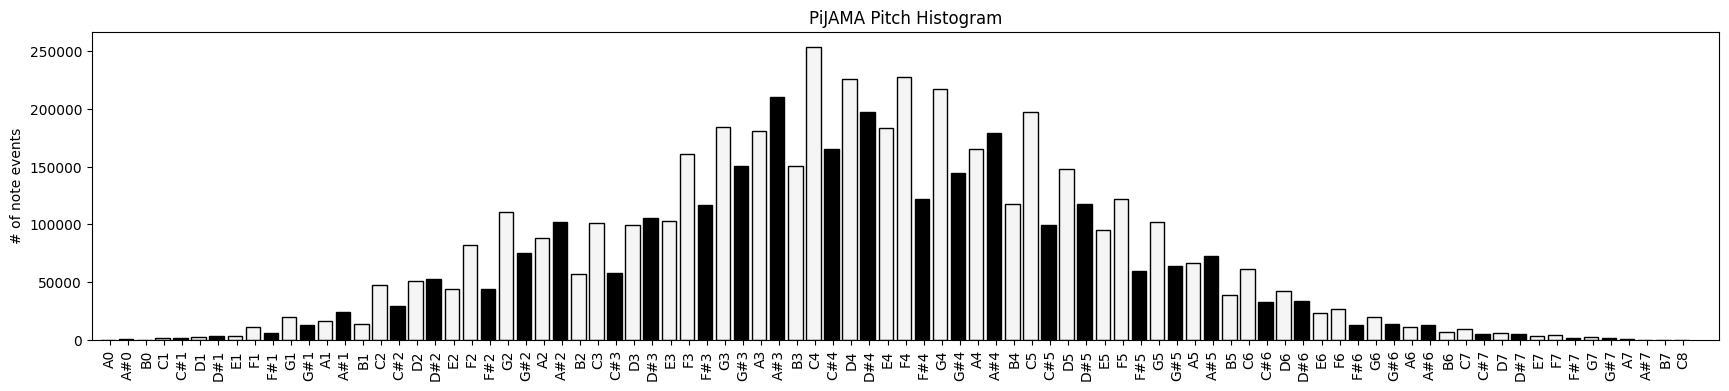

In [97]:
plt.figure(figsize=(21, 4))
note_names = list(map(lambda x: pm.note_number_to_name(x), range(21, 109)))
N, bins, patches = plt.hist(pitches, bins=np.arange(20.5, 109.5, 1), width=0.8, edgecolor = "black")
for note_name, patch in zip(note_names, patches):
    if '#' in note_name:
        patch.set_facecolor("black")
    else:
        patch.set_facecolor("whitesmoke")
        
plt.xlim([20, 110])
plt.xticks(range(21, 109), labels=note_names, rotation=90)
plt.title("PiJAMA Pitch Histogram")
plt.ylabel("# of note events")
None

Below we produce artist pitch histograms for the 30 artists in the PiJAMA-30 subset. In the paper we show the pitch profiles of Jessica Williams and Erroll Garner. 

/import/c4dm-datasets-ext/ace01/PiJAMA/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


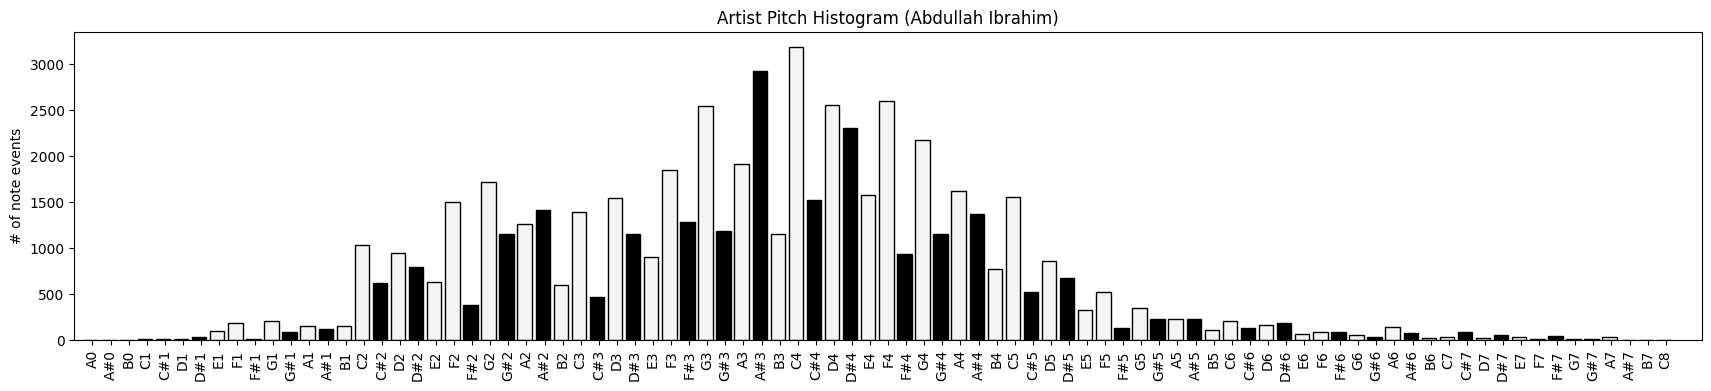

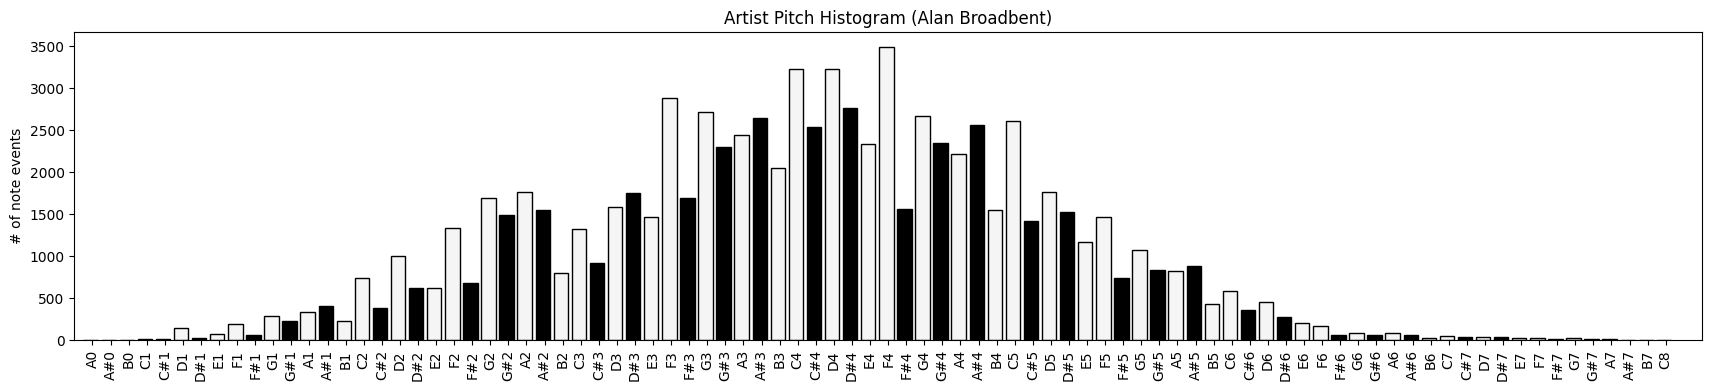

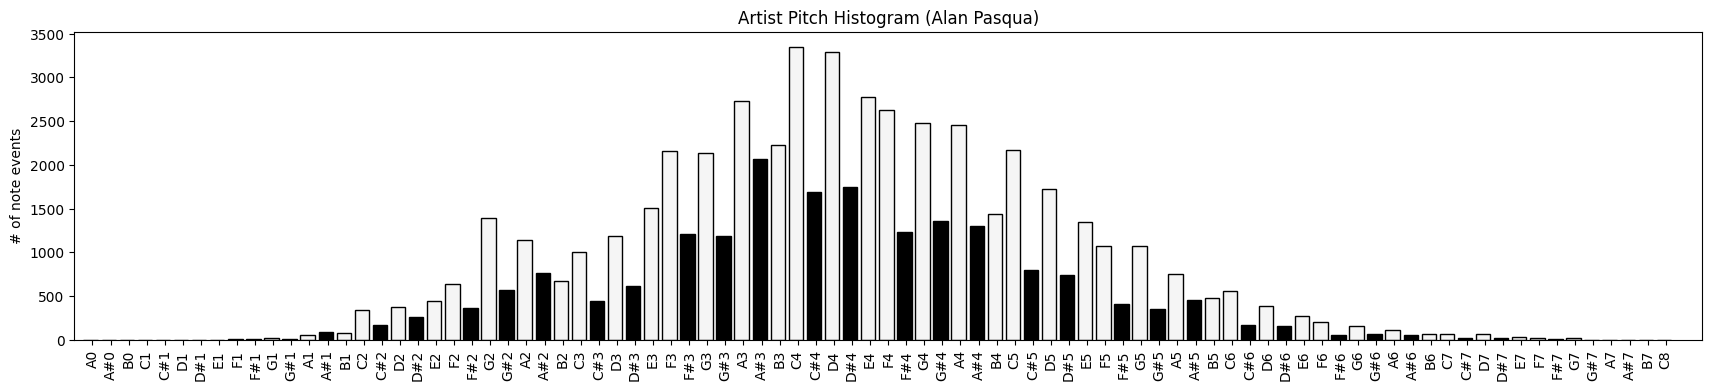

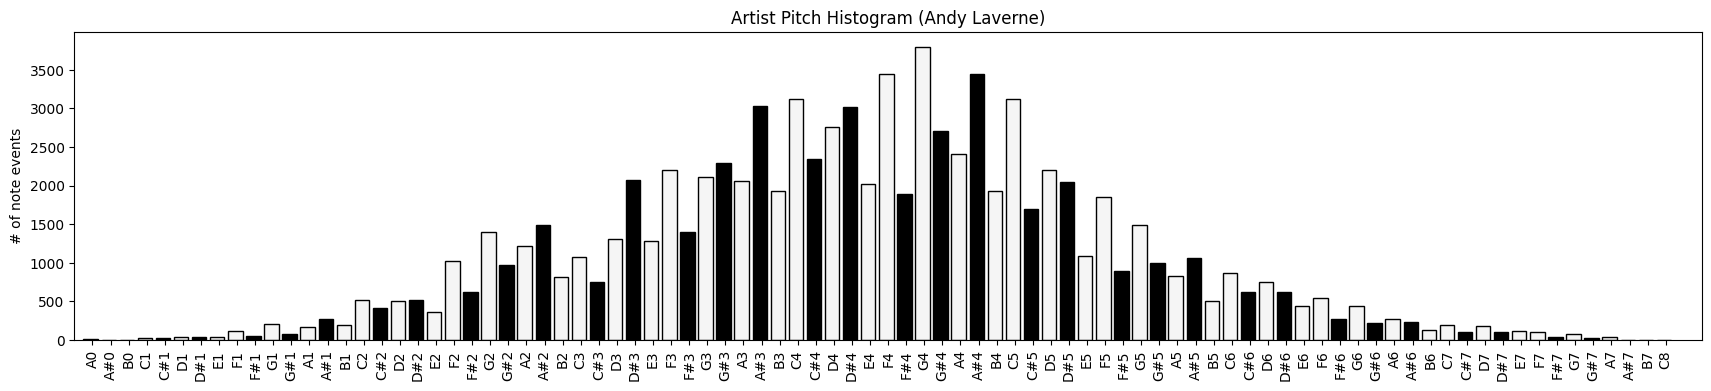

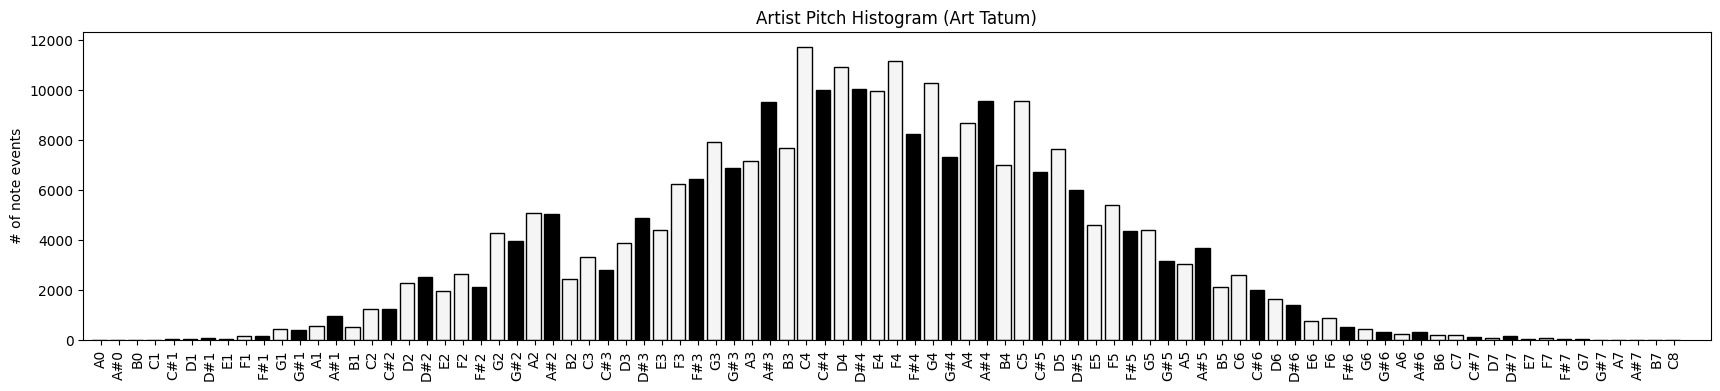

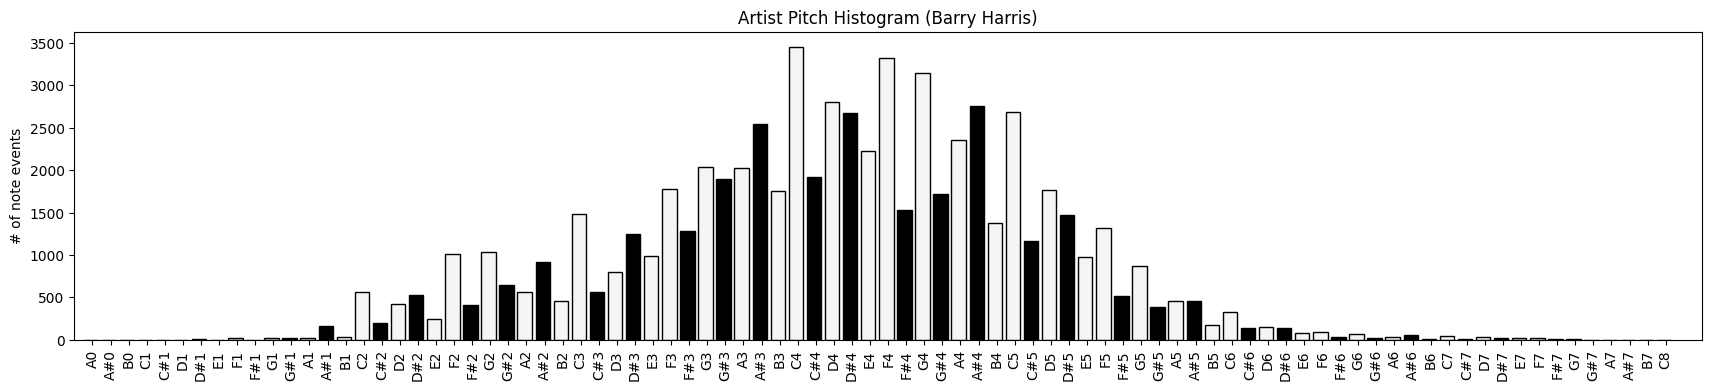

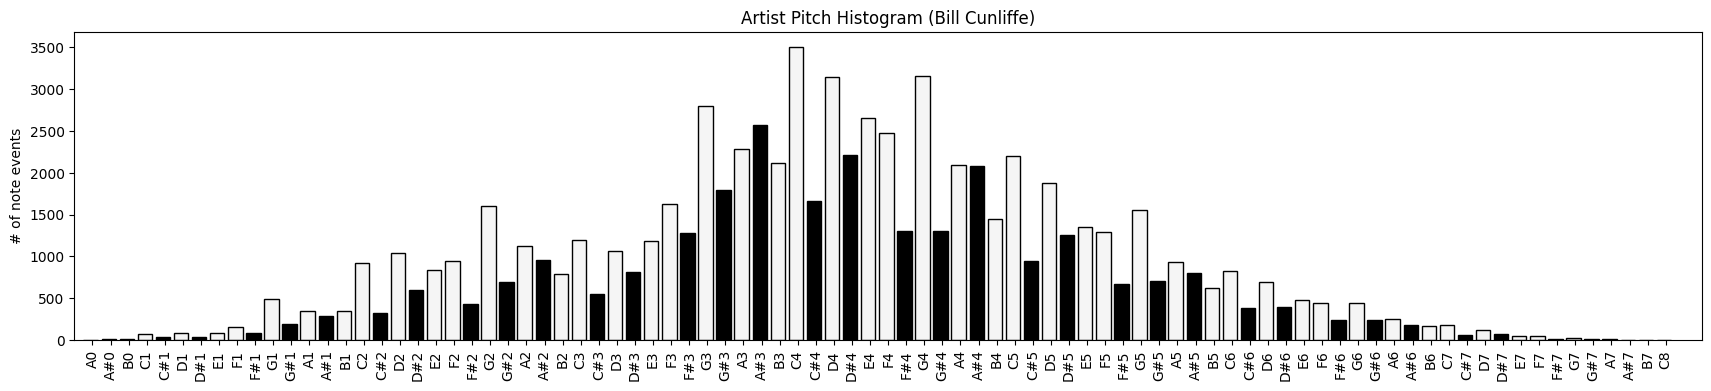

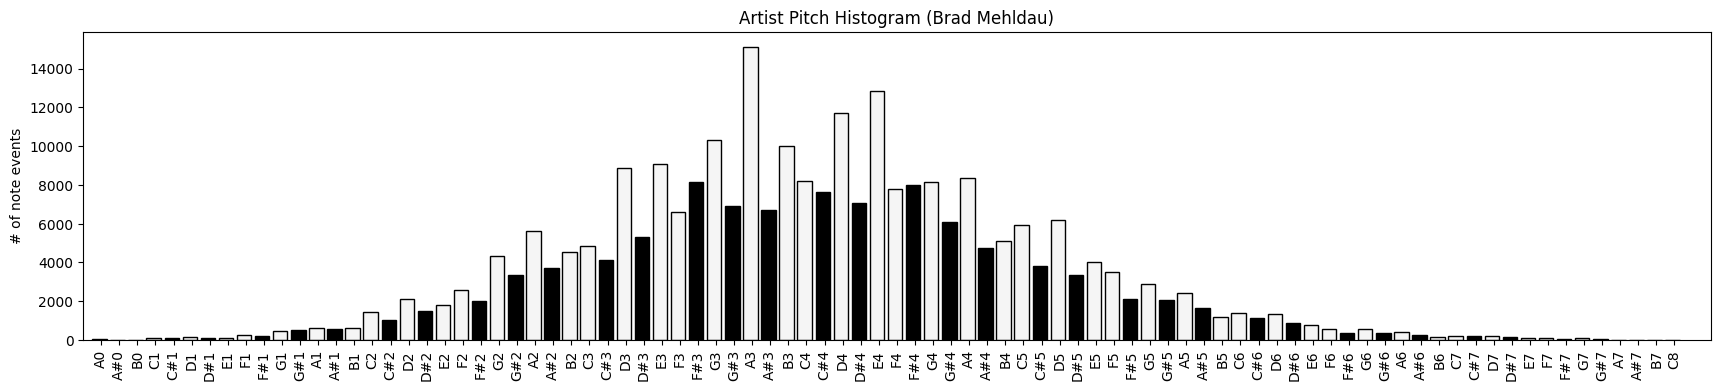

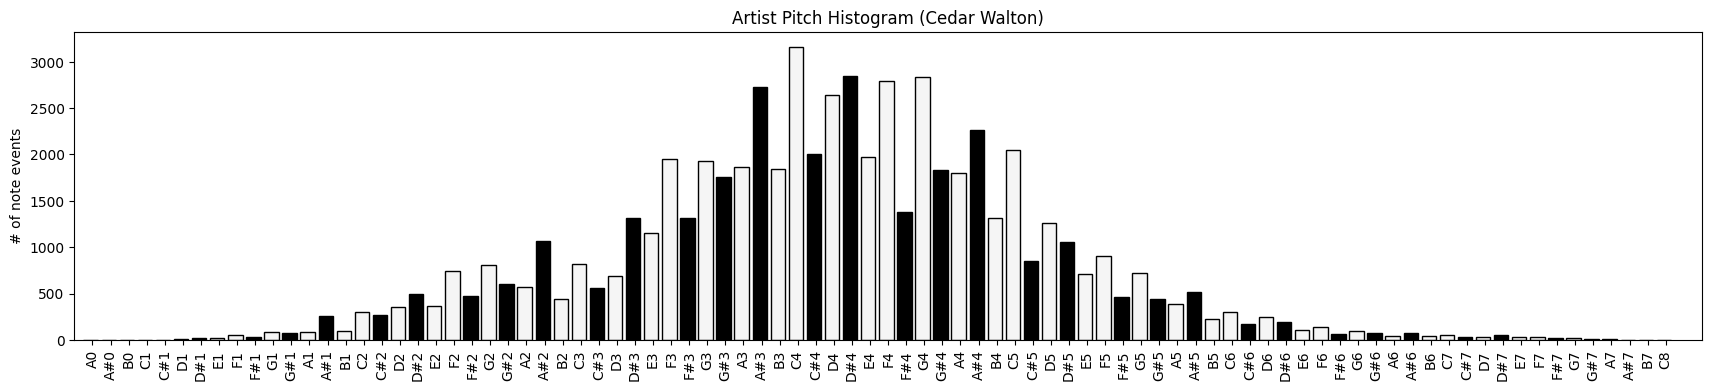

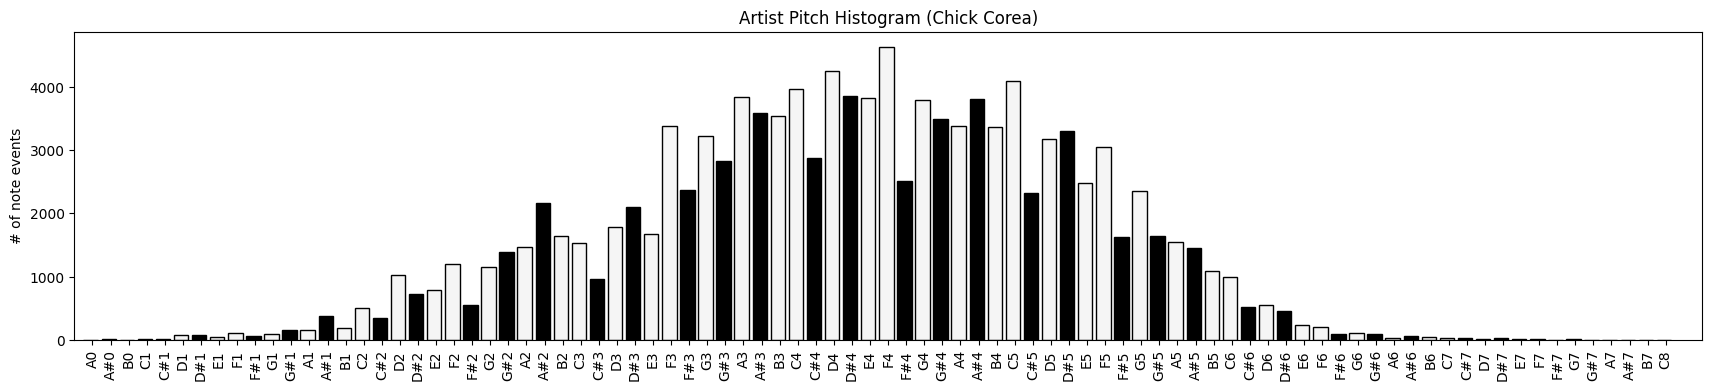

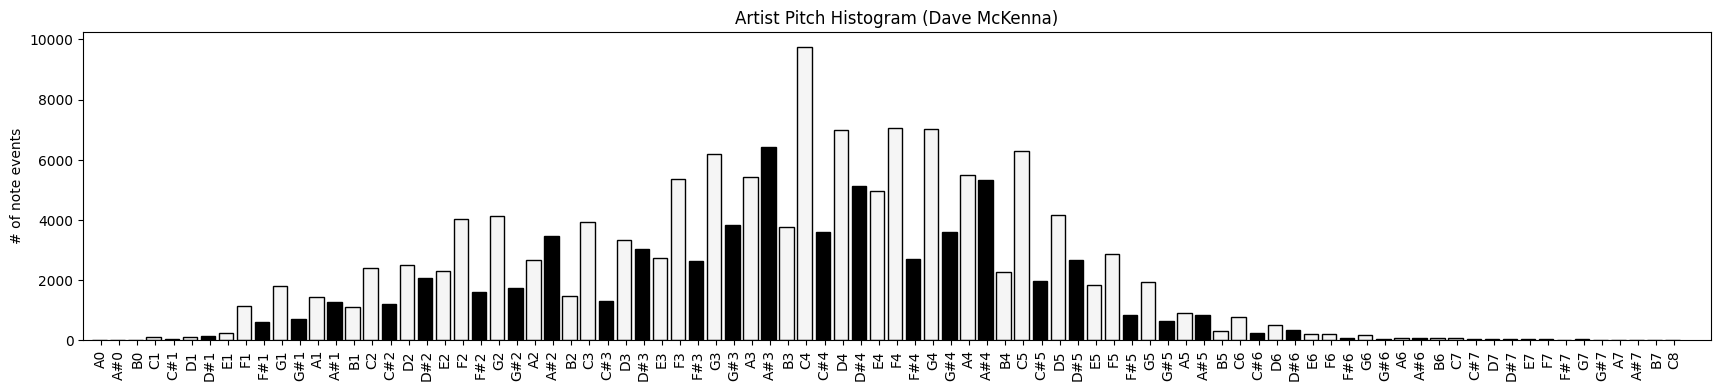

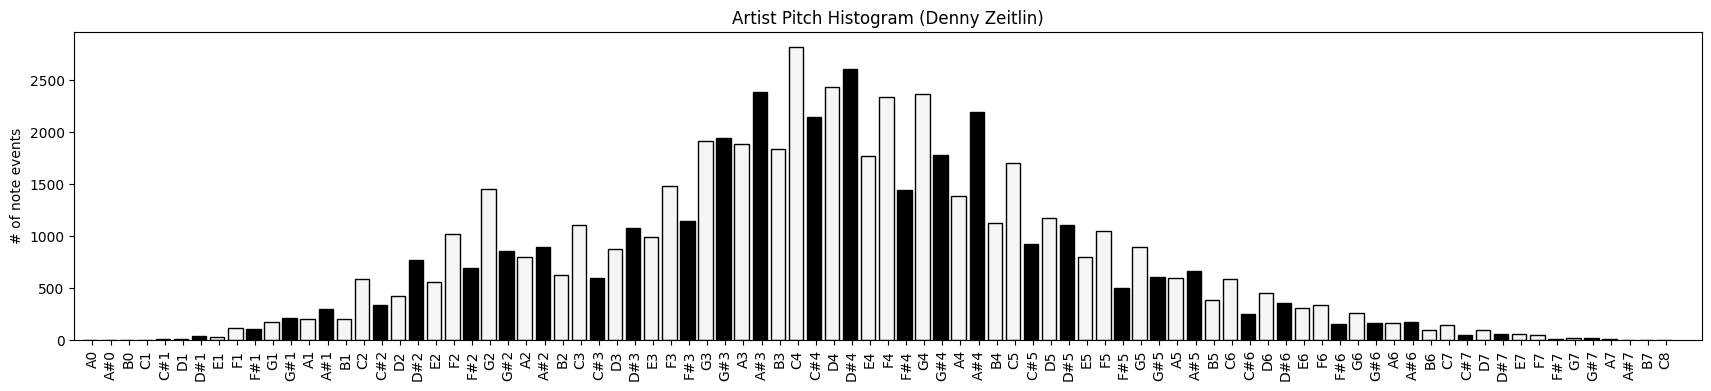

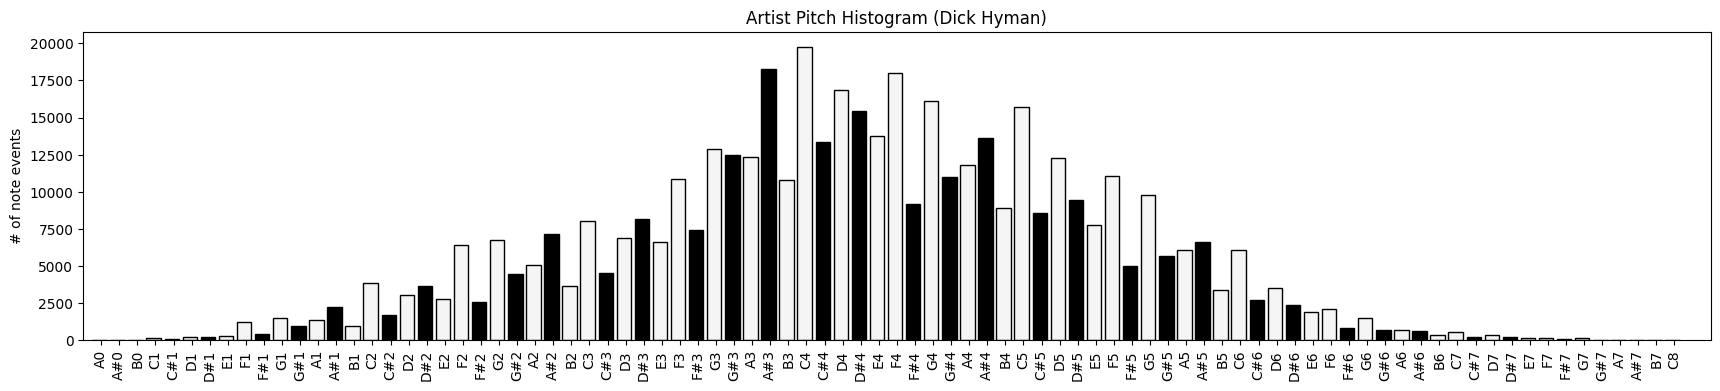

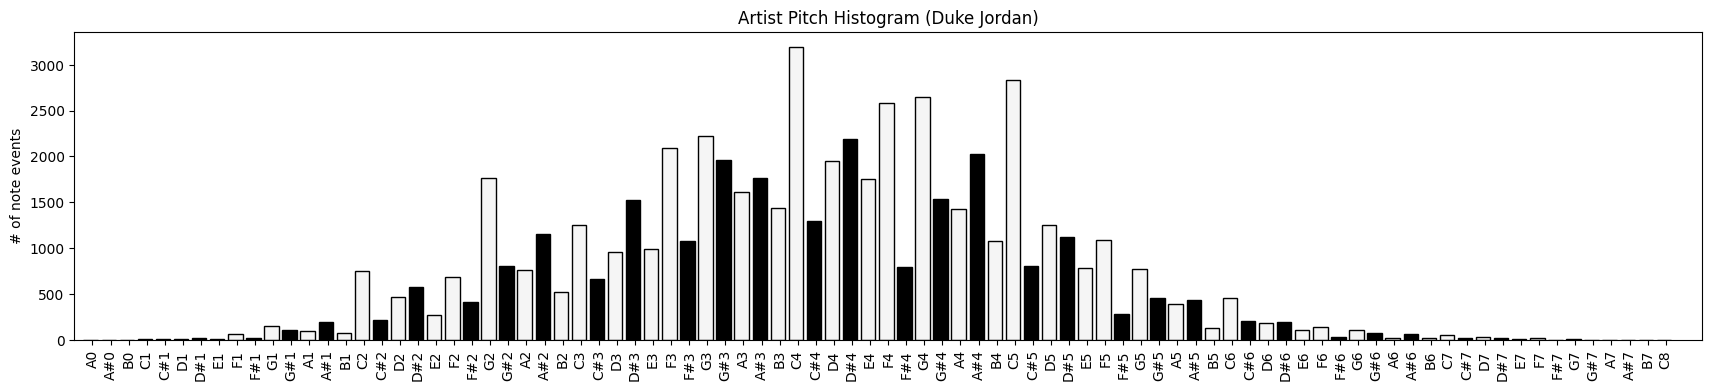

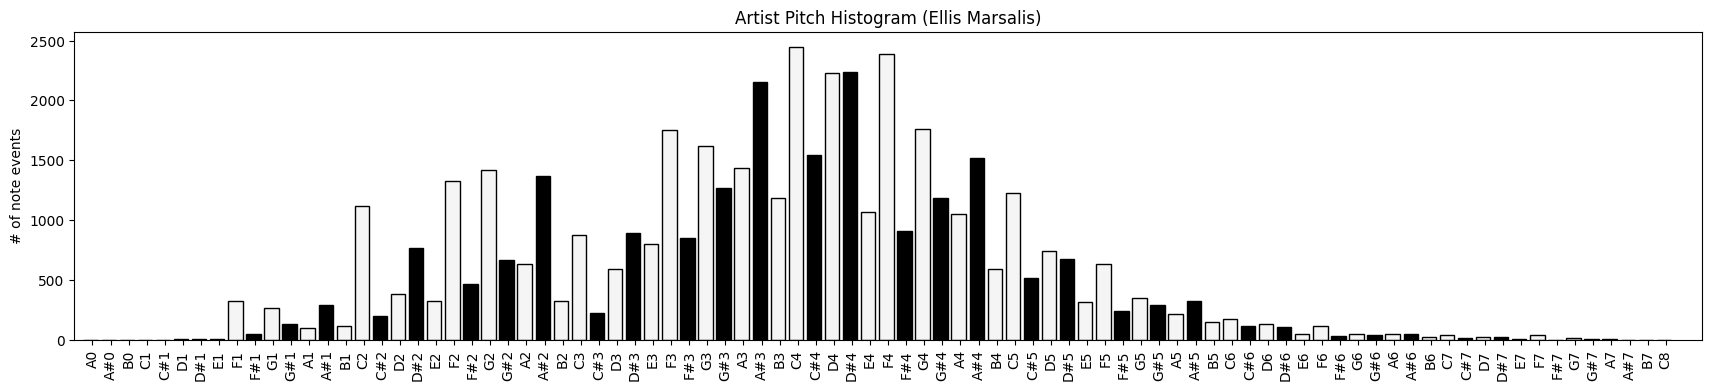

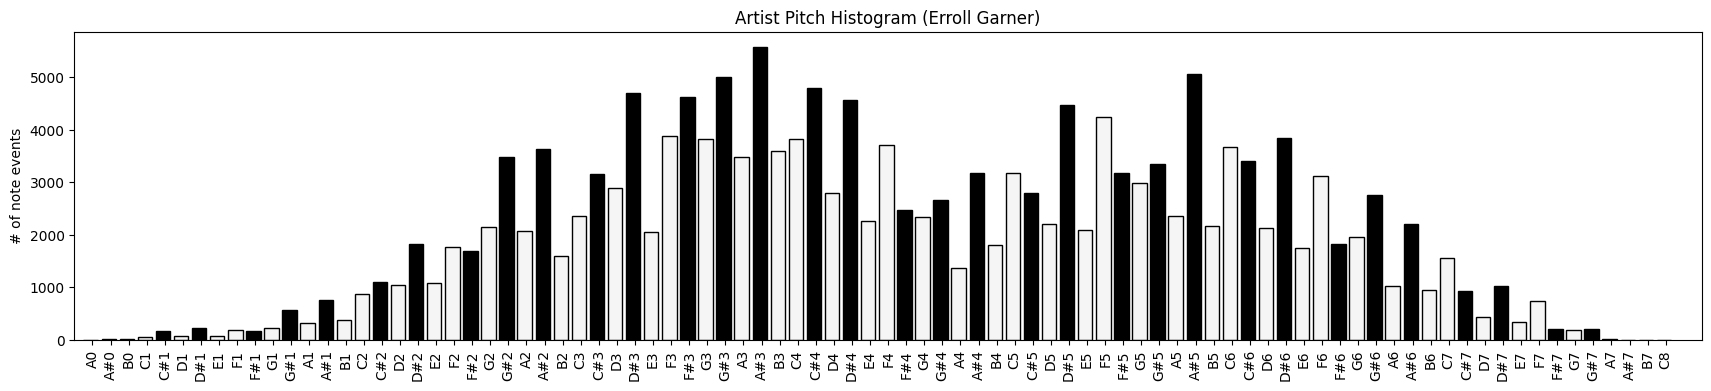

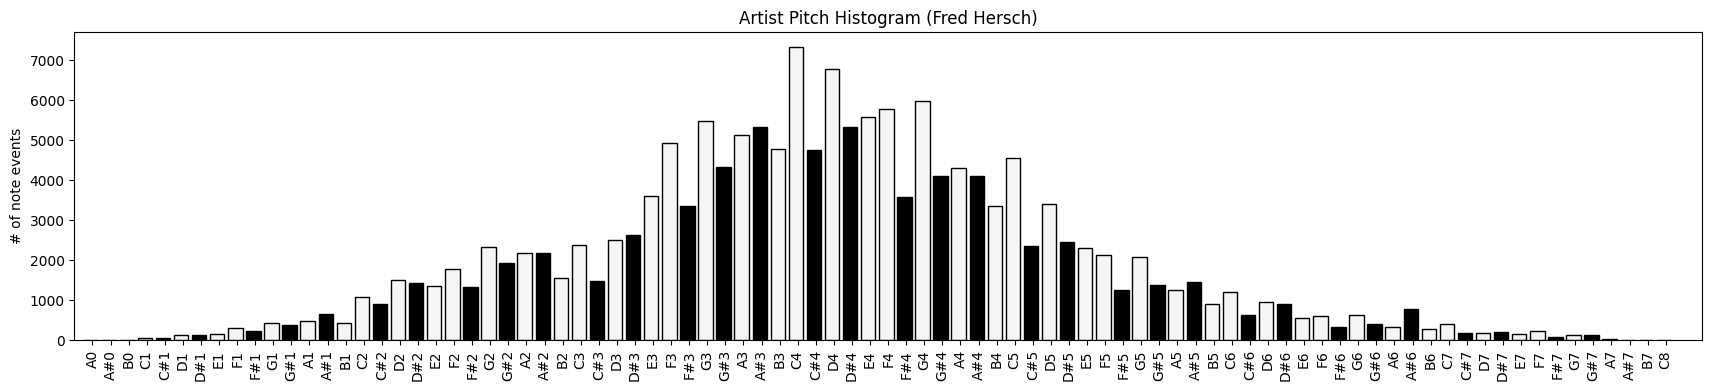

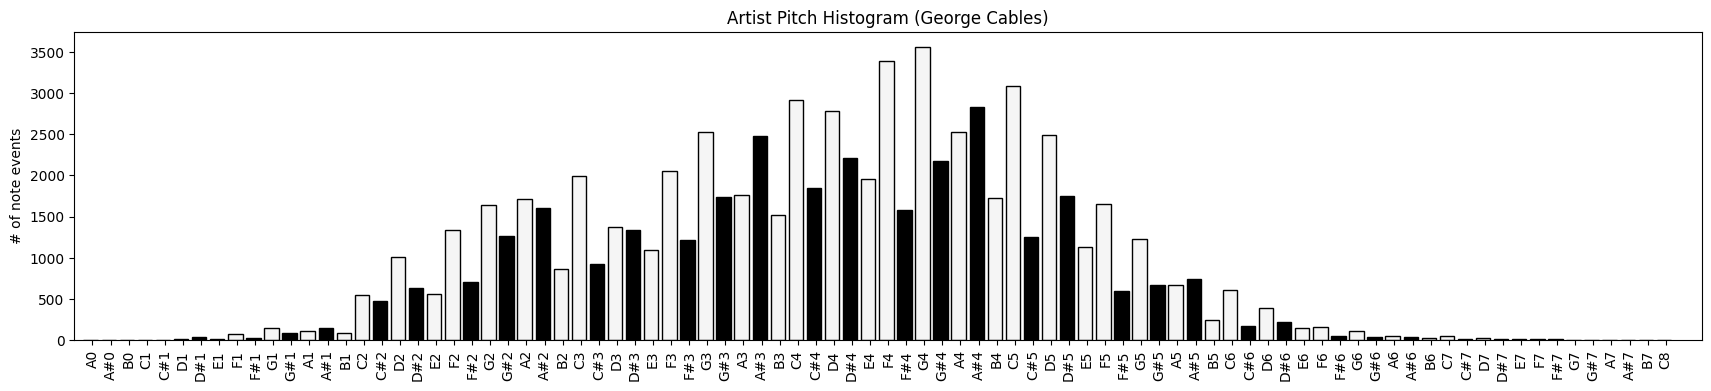

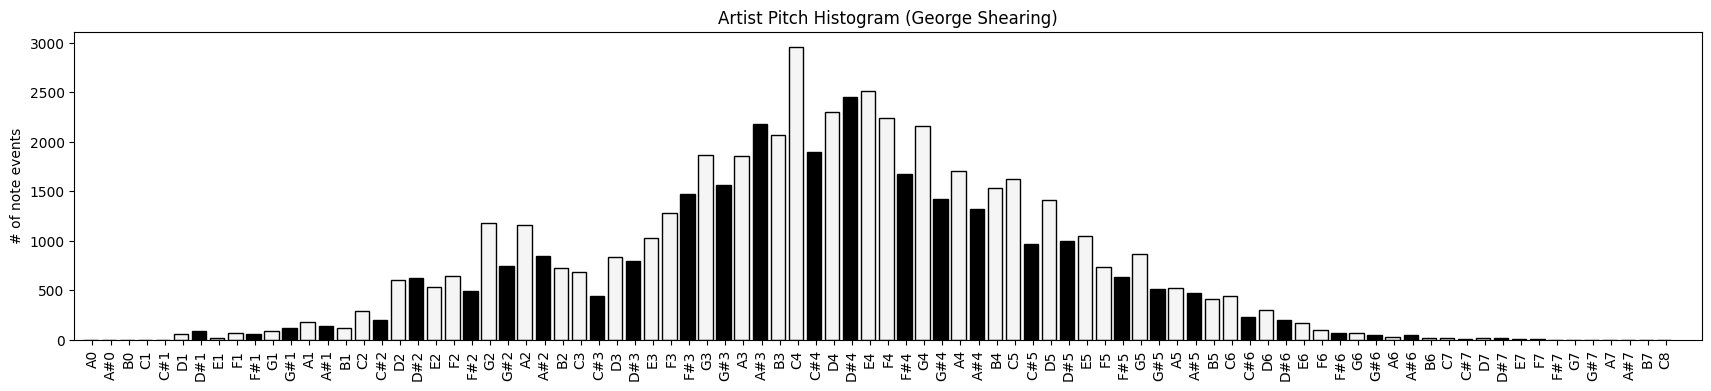

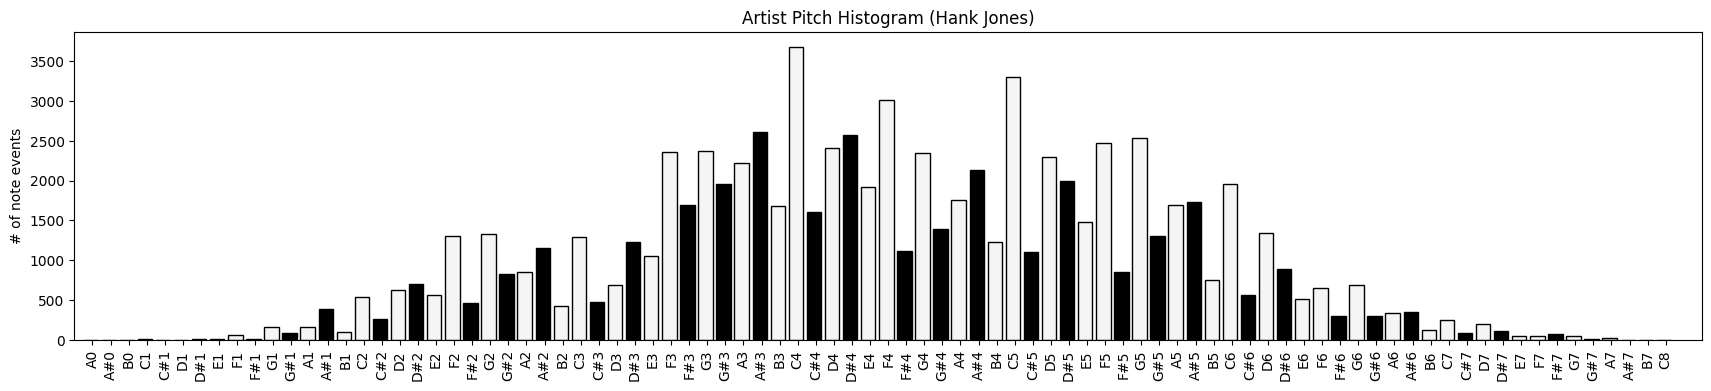

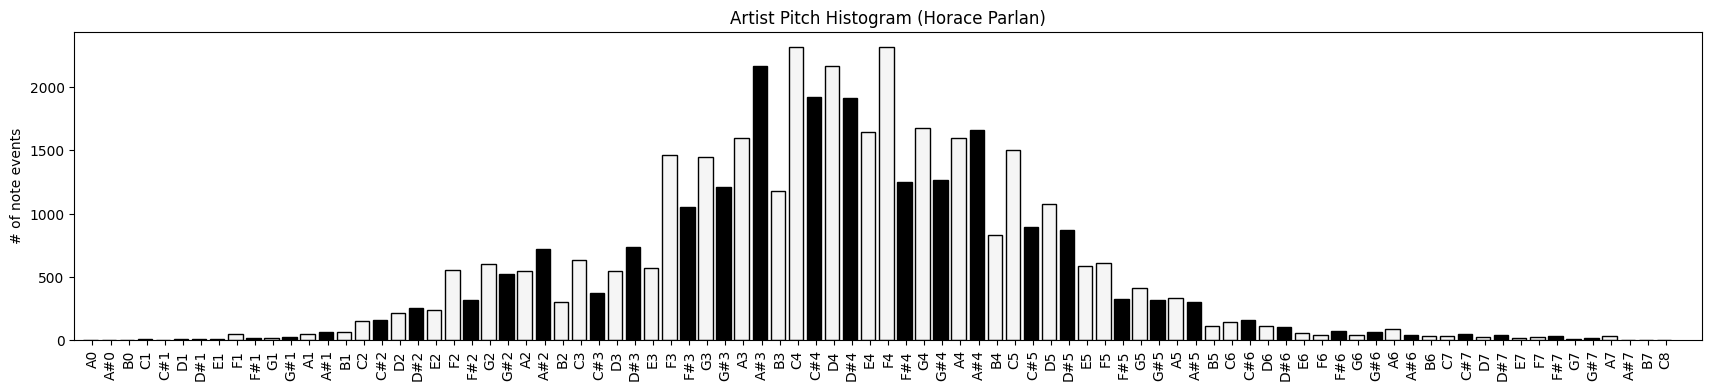

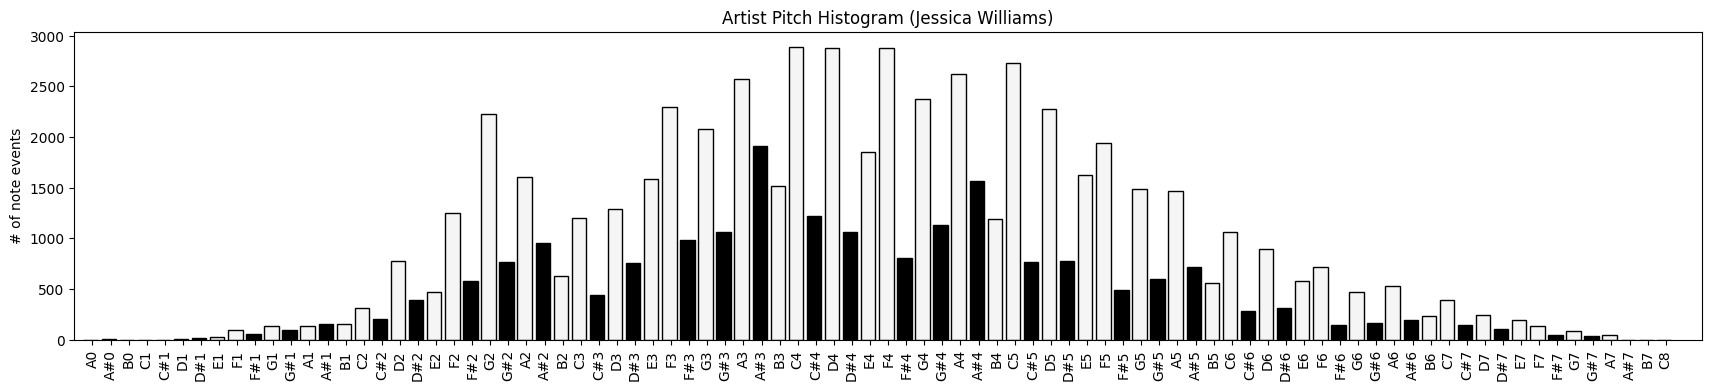

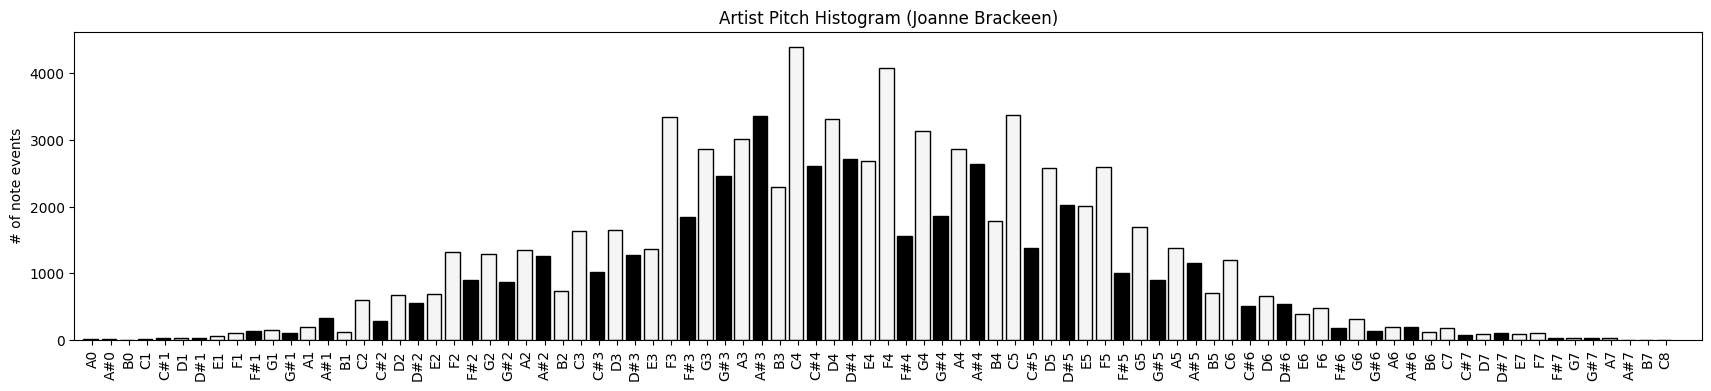

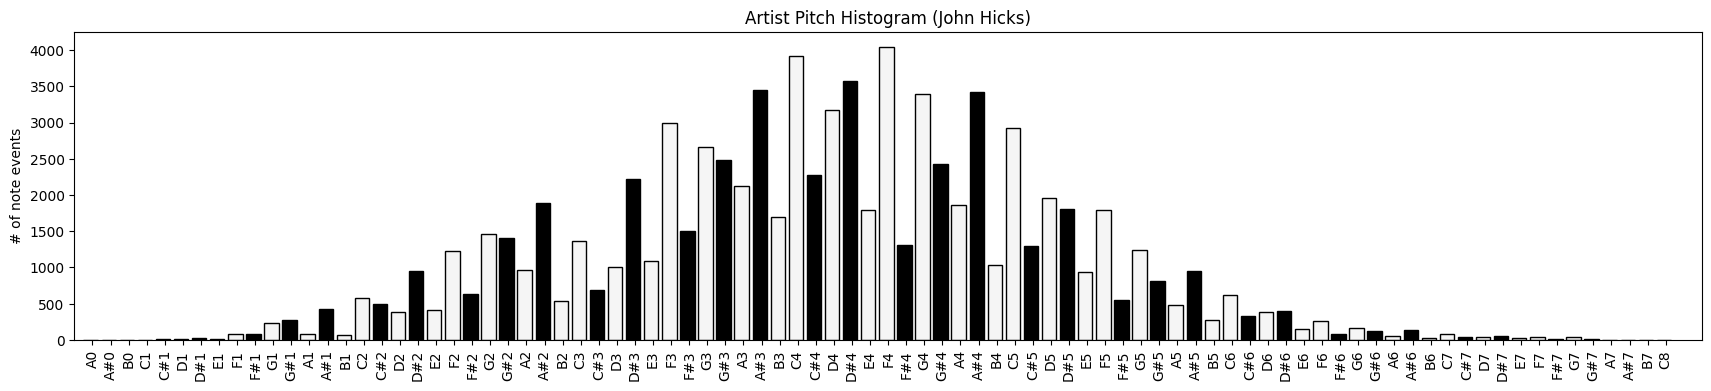

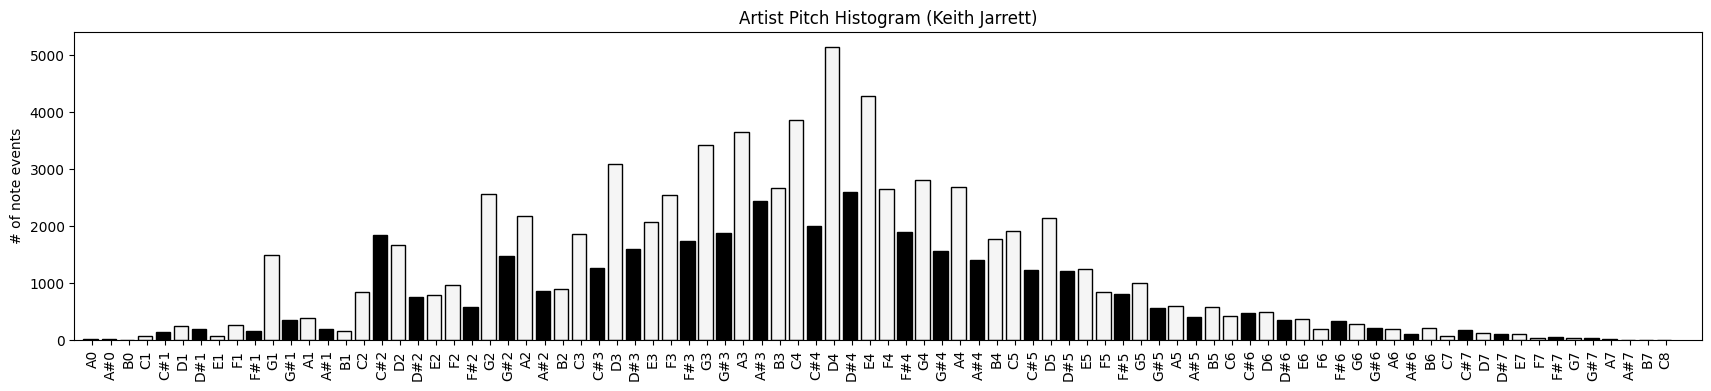

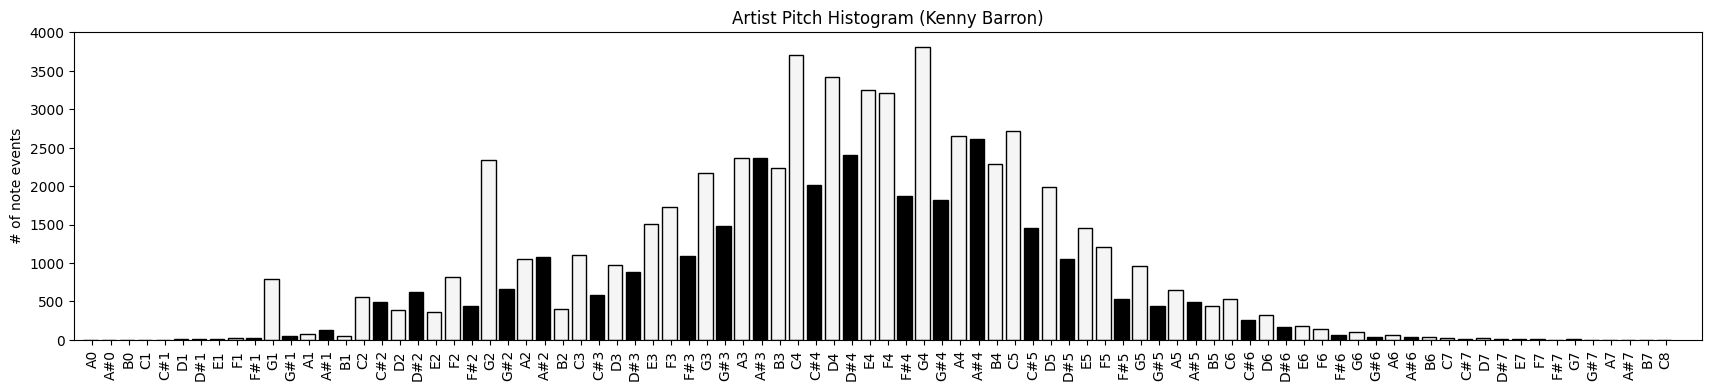

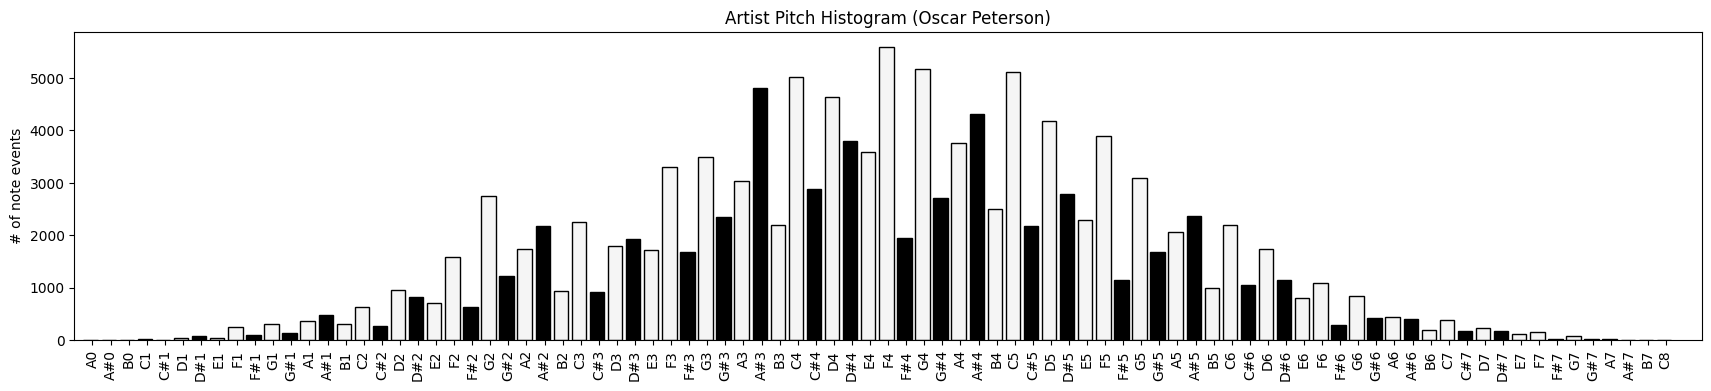

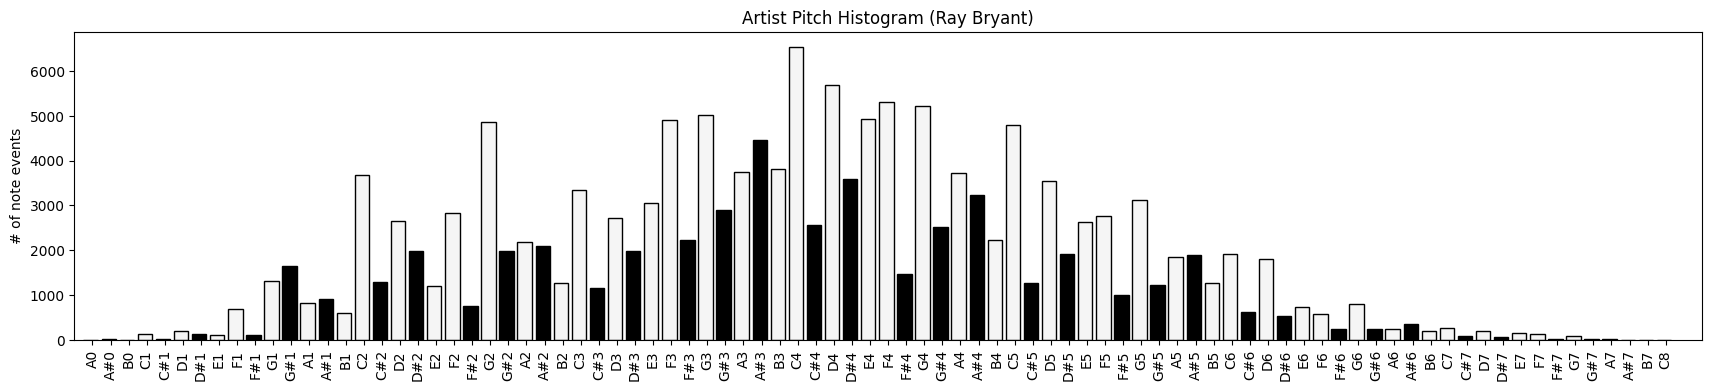

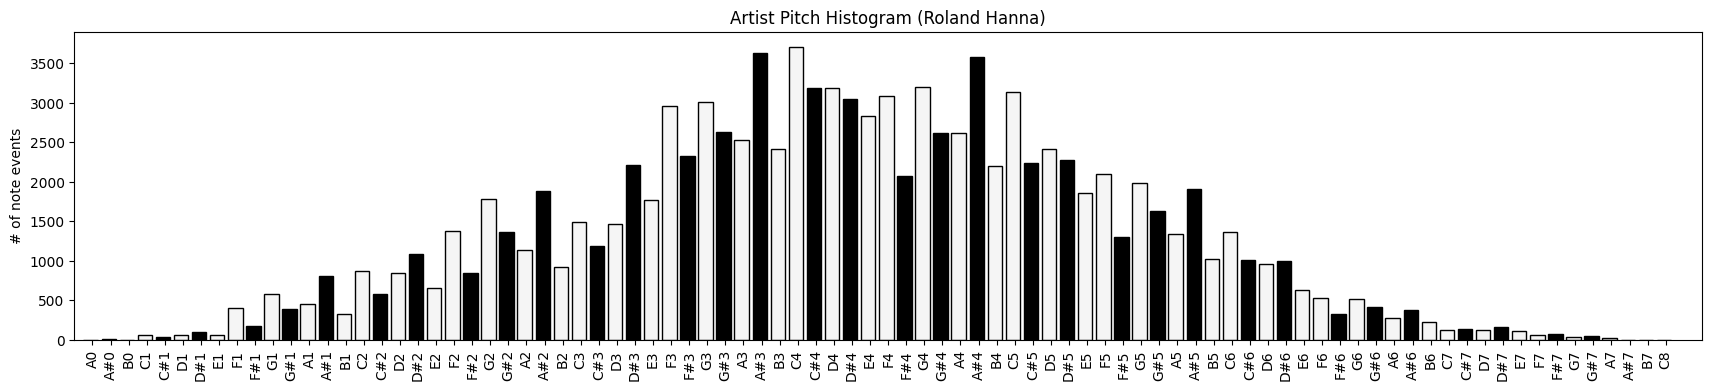

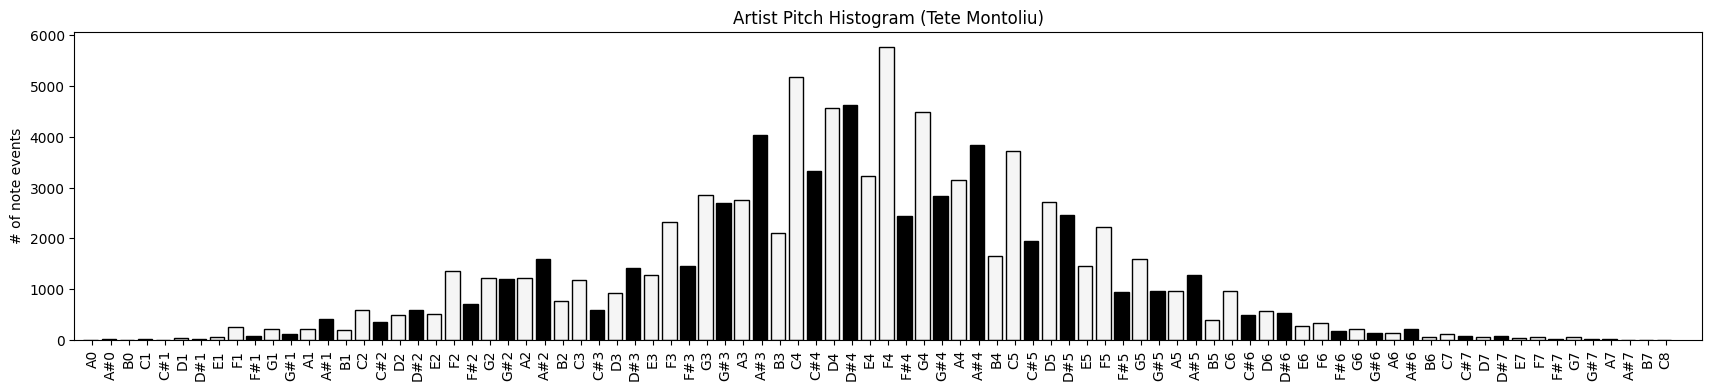

In [112]:
def note_freq_hist(pitches, title="PiJAMA Pitch Histogram"):
    plt.figure(figsize=(21, 4))
    note_names = list(map(lambda x: pm.note_number_to_name(x), range(21, 109)))
    N, bins, patches = plt.hist(pitches, bins=np.arange(20.5, 109.5, 1), width=0.8, edgecolor = "black")
    for note_name, patch in zip(note_names, patches):
        if '#' in note_name:
            patch.set_facecolor("black")
        else:
            patch.set_facecolor("whitesmoke")

    plt.xlim([20, 110])
    plt.xticks(range(21, 109), labels=note_names, rotation=90)
    plt.title(title)
    plt.ylabel("# of note events")
    return N, bins

artist_note_events = df_30.groupby("artist")["note_events"].agg(sum)
for artist, note_events in artist_note_events.iteritems():
    pitches = [note.pitch for note in note_events]
    N, bins = note_freq_hist(pitches, title=f"Artist Pitch Histogram ({artist})")
    Z = sum(N)
    #print(artist)
    #print(sum(i*n/Z for i, n in enumerate(N)))

## Notes per Second <a class="anchor" id="nps"></a>

Below we reproduce Figure 7 from the paper, which plots each pianists notes per second, averaged across performances.

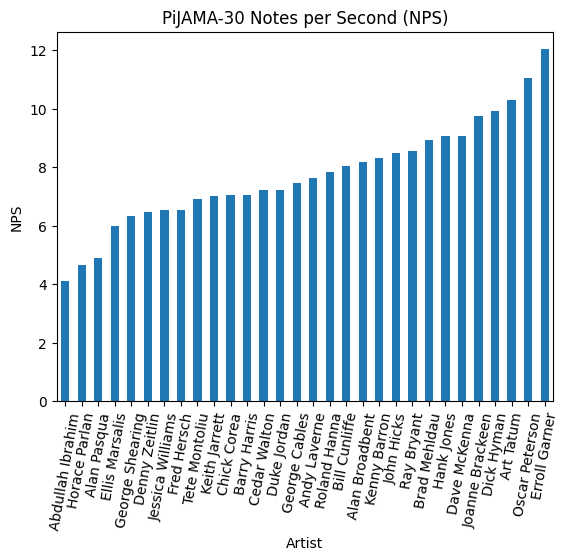

In [118]:
df['number_of_notes'] = df.apply(lambda row: len(note_events_row(row)), axis=1)
df['note_events'] = df.apply(lambda row: note_events_row(row), axis=1)
artist_note_counts = df.groupby("artist").sum(["performance_start_sec", "performance_end_sec", "number_of_notes"])
artist_note_counts["nps"] = artist_note_counts.apply(lambda row: row["number_of_notes"]/(row["performance_end_sec"] - row["performance_start_sec"]), axis=1)

df_30['number_of_notes'] = df.number_of_notes[df_30.original_index].values
df_30['note_events'] = df.note_events[df_30.original_index].values
artist_note_counts_30 = df_30.groupby("artist").sum(["performance_start_sec", "performance_end_sec", "number_of_notes"])
artist_note_counts_30["nps"] = artist_note_counts.apply(lambda row: row["number_of_notes"]/(row["performance_end_sec"] - row["performance_start_sec"]), axis=1)
artist_note_counts_30.sort_values("nps")["nps"].plot.bar()
plt.title("PiJAMA-30 Notes per Second (NPS)")
plt.ylabel("NPS")
plt.xlabel("Artist")
plt.xticks(rotation=80)
None

## Sliding Pitch Class Entropy (SPCE) <a class="anchor" id="spce"></a>

Below we give the precise computational definition of Sliding Pitch Class Entorpy (SPCE). For each window of time (e.g. 15 seconds), we compute the [pitch class entropy](https://salu133445.github.io/muspy/doc/muspy.html#muspy.pitch_class_entropy). The SPCE of a performance is the average of these values. 

In [143]:
def windowed_pce(note_events, window=15):
    note_events = sorted(note_events, key=lambda x: x.start)
    if note_events[-1].end < window:
        window = int(note_events[-1].end)
    t_min = int(note_events[0].start)
    t_max = int(note_events[-1].end) + 1
    idx = 0
    current_notes = []
    pce_windows = []
    for t in range(t_min, t_max - window):
        # keep only those starting in the new window
        keep_idx = 0
        while keep_idx < len(current_notes) and current_notes[keep_idx].start < t:
            keep_idx += 1
        current_notes = current_notes[keep_idx:]
        
        # add notes events from the new window
        while idx < len(note_events) and note_events[idx].start < t + window:
            current_notes.append(note_events[idx])
            idx += 1
        
        pitch_classes = [note.pitch % 12 for note in current_notes]
        pitch_class_counts = Counter(pitch_classes)
        Z = len(pitch_classes)
        pitch_class_probabilities = [pc/Z for pc in pitch_class_counts.values()]
        pce_windows.append(sum(-p * np.log(p) if p > 0 else 0 for p in pitch_class_probabilities))

    return pce_windows

def spce(note_events, window=15):
    return np.mean(windowed_pce(note_events, window))

Here we reproduce Figure 8 from the paper to show the sorted SPCE of pianists in PiJAMA-30.

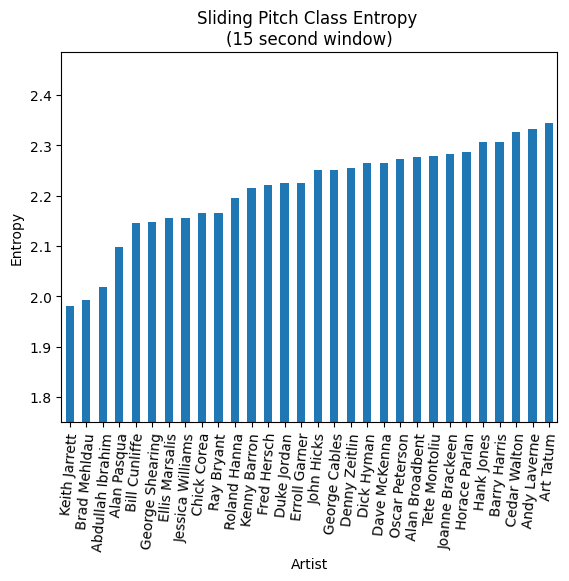

In [144]:
df['sliding_pitch_class_entropy'] = df.apply(lambda row: spce(row["note_events"], 15), axis=1)
df_30['sliding_pitch_class_entropy'] = df.sliding_pitch_class_entropy[df_30.original_index].values
max_entropy = sum(-p * np.log(p) if p > 0 else 0 for p in [1/12 for _ in range(12)])
df_30.groupby("artist").mean()["sliding_pitch_class_entropy"].sort_values().plot.bar()
plt.title("Sliding Pitch Class Entropy \n(15 second window)")
plt.ylabel("Entropy")
plt.ylim([1.75, max_entropy])
plt.xlabel("Artist")
plt.xticks(rotation=85)
None

Finally, we look at a few examples of songs with high and low SPCE. 

In [145]:
df[['sliding_pitch_class_entropy','artist','title','youtube_url']].sort_values('sliding_pitch_class_entropy')

,sliding_pitch_class_entropy,artist,title,youtube_url
id,,,,
2568,0.830563,Keith Jarrett,"Pt. X - Royal Festival Hall, London - Live",https://www.youtube.com/watch?v=g4Qw6lXT2fs
1961,1.278842,Vijay Iyer,Prelude - Heartpiece,https://www.youtube.com/watch?v=cXeEIDX0V7M
1727,1.341624,Gonzalo Rubalcaba,Derivado 2,https://www.youtube.com/watch?v=iTTocbWzLno
884,1.405341,Gonzalo Rubalcaba,Rezo (Praise Be!),https://www.youtube.com/watch?v=SXx_8NLPOR4
1020,1.463570,Abdullah Ibrahim,Machopi,https://www.youtube.com/watch?v=Ru11FwIUx00
...,...,...,...,...
739,2.429622,Gonzalo Rubalcaba,Improvisation 2 (Based On 'Coltrane Changes'),https://www.youtube.com/watch?v=lahKiVtErUk
1614,2.429688,Joanne Brackeen,Minued,https://www.youtube.com/watch?v=NdfaRkIdT6c
629,2.433557,Dick Hyman,Time Play,https://www.youtube.com/watch?v=kqFxnuO78KM


Below are the four lowest scoring SCPE. The performances either use a very small set of notes or are very sparse. 

One possible criticism of this metric is that averaging across an entire song will cause regions of silence to pull the score lower. 

In [8]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/g4Qw6lXT2fs" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe> 0.830563
<iframe width="560" height="315" src="https://www.youtube.com/embed/cXeEIDX0V7M" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe> 1.278842
<iframe width="560" height="315" src="https://www.youtube.com/embed/iTTocbWzLno" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe> 1.341624
<iframe width="560" height="315" src="https://www.youtube.com/embed/SXx_8NLPOR4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe> 1.405341

Here we show the four highest scoring PCE performances. These tend to have a lot of chromatic and denser playing. It is probably worth mentioning that the Dick Hyman performances are from a series of etudes he wrote, which may intentionally have more extreme chromaticism and rapid modulation as a pedagogical device. And it is also interesting that the other two of the top four come from the same album by Joanne Brackeen. 

In [7]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/QTiO6OptOv0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe> 2.441436
<iframe width="560" height="315" src="https://www.youtube.com/embed/thp4l9qu45E" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe> 2.436660
<iframe width="560" height="315" src="https://www.youtube.com/embed/kqFxnuO78KM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe> 2.433557
<iframe width="560" height="315" src="https://www.youtube.com/embed/NdfaRkIdT6c" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe> 2.429688